In [ ]:
#| hide
!pip install -Uqq nixtla
!pip install shap

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# SHAP Values

SHAP (SHapley Additive exPlanation) values use game theory to explain the output of any machine learning models. It allows us to explore in detail how exogenous features impact the final forecast, both at a single forecast step or over the entire horizon. 

When you forecast with exogenous features, you can access the SHAP values for all series at each prediction step, and use the popular [shap](https://shap.readthedocs.io/en/latest/) Python package to make different plots and explain the impact of the features.

This tutorial assumes knowledge on forecasting with exogenous features, so make sure to read our tutorial on [exogenous variables](https://docs.nixtla.io/docs/tutorials-exogenous_variables). Also, the `shap` package must be installed separately as it is not a dependency of `nixtla`.

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/tutorials/01_exogenous_variables')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/01_exogenous_variables.ipynb)

## 1. Import packages
First, we import the required packages and initialize the Nixtla client.

In [ ]:
import pandas as pd
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
> 
> To use an Azure AI endpoint, remember to set also the `base_url` argument:
> 
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient(base_url="http://0.0.0.0:8000")

## 2. Load data

Let's see an example on predicting day-ahead electricity prices. The following dataset contains the hourly electricity price (`y` column) for five markets in Europe and US, identified by the `unique_id` column. The columns from `Exogenous1` to `day_6` are exogenous variables that TimeGPT will use to predict the prices.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-with-ex-vars.csv')
df.head()

,unique_id,ds,y,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,BE,2016-10-22 00:00:00,70.00,49593.0,57253.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,BE,2016-10-22 01:00:00,37.10,46073.0,51887.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,BE,2016-10-22 02:00:00,37.10,44927.0,51896.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,BE,2016-10-22 03:00:00,44.75,44483.0,48428.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,BE,2016-10-22 04:00:00,37.10,44338.0,46721.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 3. Forecasting electricity prices using exogenous variables

To produce forecasts we also have to add the future values of the exogenous variables. Let's read this dataset. In this case, we want to predict 24 steps ahead, therefore each `unique_id` will have 24 observations.

::: {.callout-important}
If you want to use exogenous variables when forecasting with TimeGPT, you need to have the future values of those exogenous variables too.
::: 

In [ ]:
future_ex_vars_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-future-ex-vars.csv')
future_ex_vars_df.head()

,unique_id,ds,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,BE,2016-12-31 00:00:00,64108.0,70318.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,BE,2016-12-31 01:00:00,62492.0,67898.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,BE,2016-12-31 02:00:00,61571.0,68379.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,BE,2016-12-31 03:00:00,60381.0,64972.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,BE,2016-12-31 04:00:00,60298.0,62900.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Let's call the `forecast` method, adding this information. To access the SHAP values, we also need to specify `feature_contributions=True` in the `forecast` method.

In [ ]:
timegpt_fcst_ex_vars_df = nixtla_client.forecast(df=df, 
                                                 X_df=future_ex_vars_df, 
                                                 h=24, 
                                                 level=[80, 90],
                                                 feature_contributions=True)
timegpt_fcst_ex_vars_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: H
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using the following exogenous features: ['Exogenous1', 'Exogenous2', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,BE,2016-12-31 00:00:00,74.540769,84.506856,89.003951,64.574683,60.077588
1,BE,2016-12-31 01:00:00,43.344290,52.200885,57.771785,34.487695,28.916796
2,BE,2016-12-31 02:00:00,44.429219,51.034623,57.623153,37.823815,31.235285
3,BE,2016-12-31 03:00:00,38.094396,48.108951,51.528001,28.079841,24.660791
4,BE,2016-12-31 04:00:00,37.389144,46.747695,52.186026,28.030592,22.592262


## 4. Extract SHAP values

Now that we have made predictions using exogenous features, we can then extract the SHAP values using the `feature_contributions` attribute of the client. This returns a DataFrame containing the SHAP values and base values for each series, at each step in the horizon.

In [ ]:
shap_df = nixtla_client.feature_contributions
shap_df.head()

,unique_id,ds,TimeGPT,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6,base_value
0,BE,2016-12-31 00:00:00,74.540769,20.681060,14.034471,-0.040940,-1.472397,-0.208483,-0.089254,0.625051,-4.705776,2.027777,43.689260
1,BE,2016-12-31 01:00:00,43.344290,0.905773,0.436480,-0.562398,-0.091241,-0.178688,-0.081807,0.568540,-5.234938,1.671685,45.910884
2,BE,2016-12-31 02:00:00,44.429219,-3.766350,4.335490,-0.297273,0.045417,-0.143841,-0.081807,0.384336,-5.166811,1.704043,47.416015
3,BE,2016-12-31 03:00:00,38.094396,-4.522173,-1.635412,-0.286885,-0.282984,-0.151199,-0.076596,0.304731,-4.332234,1.646459,47.430688
4,BE,2016-12-31 04:00:00,37.389144,-4.208822,-1.753077,-0.150911,-0.309672,-0.169574,-0.073108,0.309639,-4.332234,1.646459,46.430442


## 5. Make plots using `shap`

Now that we have access to SHAP values we can use the `shap` package to make any plots that we want.

### 5.1 Bar plot
Here, let's make bar plots for each series and their features, so we can see which features impacts the predictions the most.

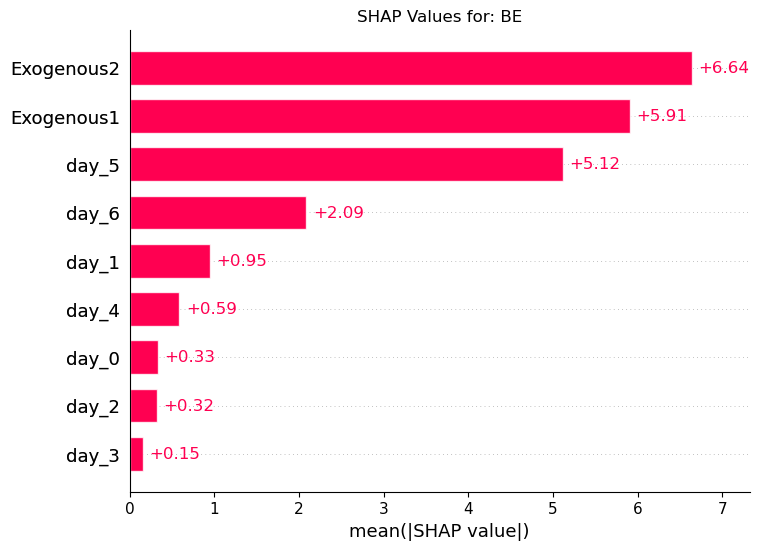

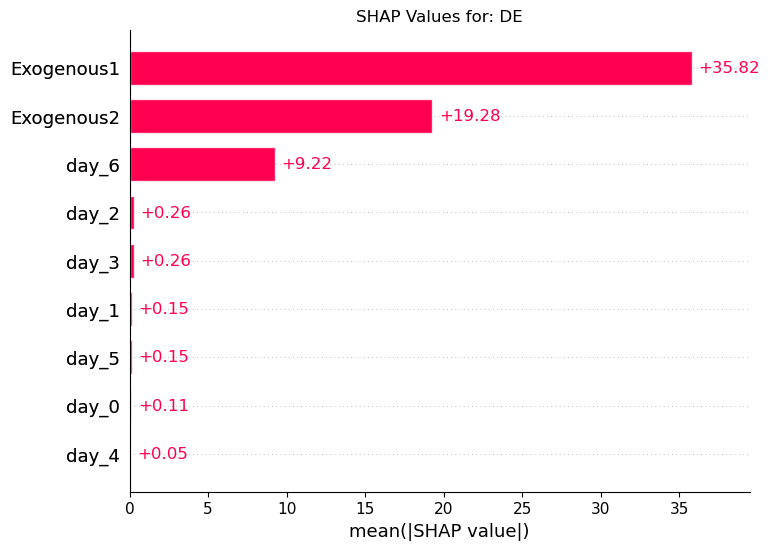

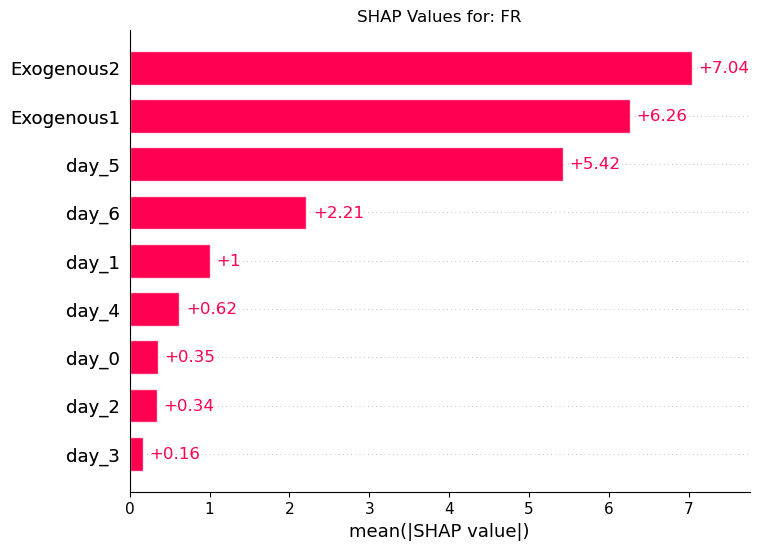

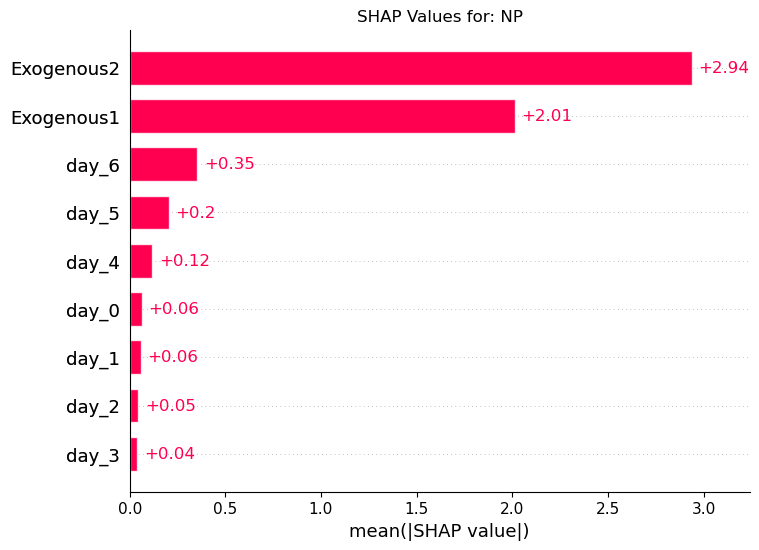

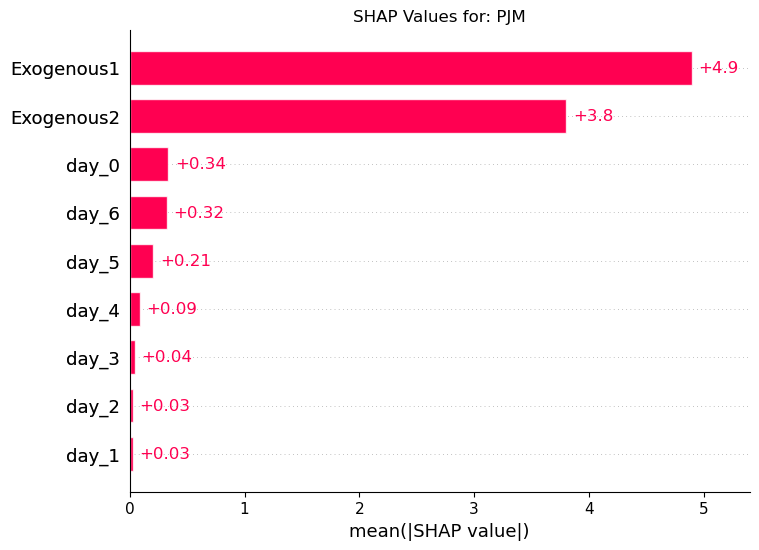

In [ ]:
import shap
import matplotlib.pyplot as plt

shap_columns = shap_df.columns.difference(['unique_id', 'ds', 'TimeGPT', 'base_value'])

# Iterate over each unique_id and create a SHAP plot
for unique_id, group in shap_df.groupby('unique_id'):
    shap_values = group[shap_columns].values # Get SHAP values
    base_values = group['base_value'].values # Get base values
    features = shap_columns 
    
    # Create a SHAP Explanation object
    shap_obj = shap.Explanation(values=shap_values, base_values=base_values, feature_names=features)
    
    # Plot the bar plot
    shap.plots.bar(shap_obj, max_display=len(features), show=False)

    plt.title(f'SHAP Values for: {unique_id}')
    plt.show()

### 5.2 Waterfall plot

Now, let's see how we can make a waterfall plot to explore the the impact of features at a single prediction step. The code below selects a series by ID and a date. Of course, this can be modified for any series or date.

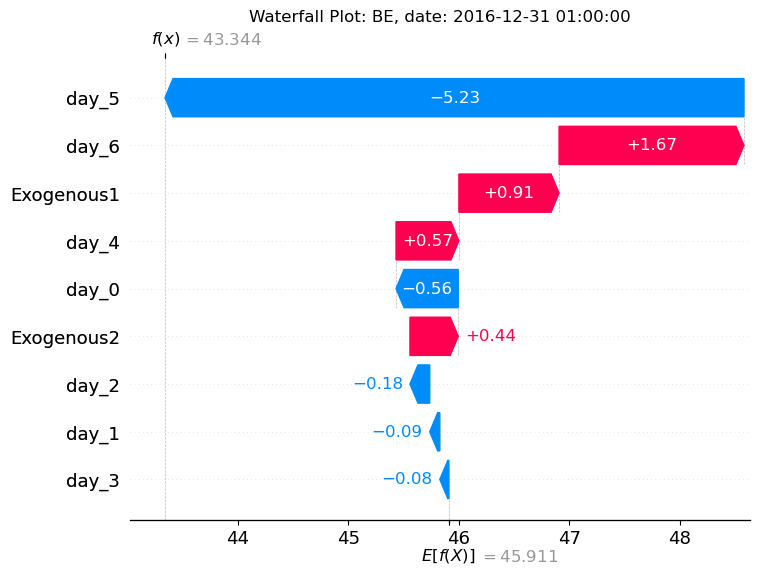

In [ ]:
selected_unique_id = 'BE'
selected_ds = '2016-12-31 01:00:00'

filtered_df = shap_df[(shap_df['unique_id'] == selected_unique_id) & (shap_df['ds'] == selected_ds)]

shap_values = filtered_df[shap_columns].values.flatten()
base_value = filtered_df['base_value'].values[0]
features = shap_columns

shap_obj = shap.Explanation(values=shap_values, base_values=base_value, feature_names=features)

shap.plots.waterfall(shap_obj, show=False)

plt.title(f'Waterfall Plot: {selected_unique_id}, date: {selected_ds}')
plt.show()

### 5.3 Heatmap
We can also do a heatmap plot to see how each feature impacts the final prediction. Here, we only need to select a specific series.

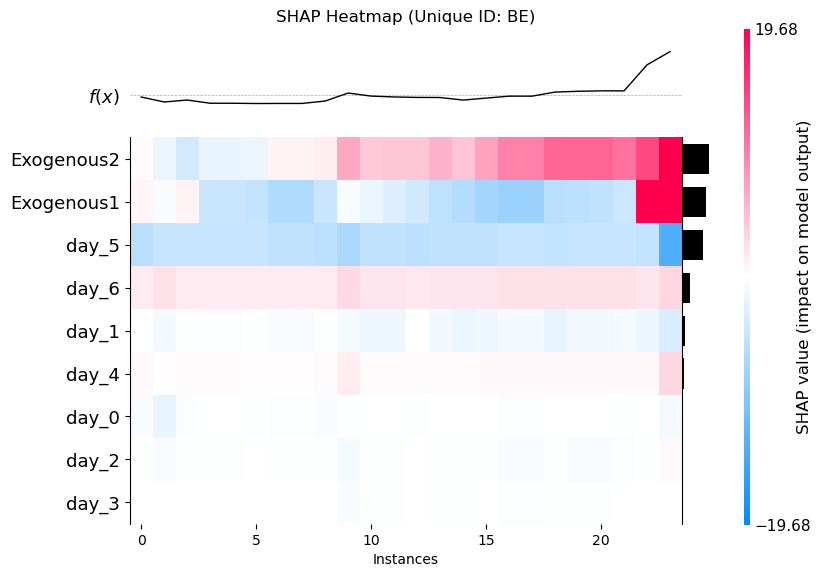

In [ ]:
selected_unique_id = 'BE'

filtered_df = shap_df[shap_df['unique_id'] == selected_unique_id]

shap_columns = filtered_df.columns.difference(['unique_id', 'ds', 'TimeGPT', 'base_value'])
shap_values = filtered_df[shap_columns].values  
feature_names = shap_columns.tolist()

shap_obj = shap.Explanation(values=shap_values, feature_names=feature_names)

shap.plots.heatmap(shap_obj, show=False)

plt.title(f'SHAP Heatmap (Unique ID: {selected_unique_id})')
plt.show()

Ultimately, the `feature_contributions` attribute gives you access to all the necessary information to explain the impact of exogenous features using the `shap` package.